In [1]:
from torch.utils.data import DataLoader
from datasets import Dataset
import pandas as pd
from preprocess_stock_data import process_apple_data
import numpy as np
import matplotlib.pyplot as plt



# Preprocess pipeline

In [2]:
file_path = 'HistoricalQuotes.csv'
df = process_apple_data(file_path)
df.head()

,Date,Last,Volume,Open,High,Low
2517,2010-03-01,29.8557,137312041,29.3928,29.9286,29.3500
2516,2010-03-02,29.8357,141486282,29.9900,30.1186,29.6771
2515,2010-03-03,29.9043,92846488,29.8486,29.9814,29.7057
2514,2010-03-04,30.1014,89591907,29.8971,30.1314,29.8043
2513,2010-03-05,31.2786,224647427,30.7057,31.3857,30.6614


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2518 entries, 2517 to 0
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2518 non-null   datetime64[ns]
 1   Last    2518 non-null   float64       
 2   Volume  2518 non-null   int64         
 3   Open    2518 non-null   float64       
 4   High    2518 non-null   float64       
 5   Low     2518 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 137.7 KB


In [4]:
df.columns

Index(['Date', 'Last', 'Volume', 'Open', 'High', 'Low'], dtype='object')

In [50]:
df.shape

(2518, 4)

In [5]:
columns_to_normalize = ['Volume', 'Open', 'High', 'Low']

# Normalize each column in place using map
df[columns_to_normalize] = df[columns_to_normalize].apply(
    lambda col: (col - col.min()) / (col.max() - col.min())
)


In [6]:
df.drop(columns=['Date','Volume'],inplace=True)

In [7]:
df.head()

,Last,Open,High,Low
2517,29.8557,0.000000,0.000000,0.003004
2516,29.8357,0.002022,0.000638,0.004113
2515,29.9043,0.001543,0.000177,0.004210
2514,30.1014,0.001707,0.000681,0.004544
2513,31.2786,0.004445,0.004891,0.007451


In [8]:
from sklearn.model_selection import train_test_split
train_df,test_df = train_test_split(df,test_size=0.2,train_size=0.8, shuffle=False)

val_df,test_df = train_test_split(test_df, test_size=0.5, train_size=0.5, shuffle=False)



In [9]:
# Split train data
train_X = train_df.drop(columns=['Last'])
train_y = train_df['Last']

# Split test data
test_X = test_df.drop(columns=['Last'])
test_y = test_df['Last']

# Split validation data
val_X = val_df.drop(columns=['Last'])
val_y = val_df['Last']

In [10]:
train_X = np.array(train_X).reshape(-1,1,3)
test_X = np.array(test_X).reshape(-1,1,3)
val_X = np.array(val_X).reshape(-1,1,3)


train_y = np.array(train_y).reshape(-1,1,1)
test_y = np.array(test_y).reshape(-1,1,1)
val_y = np.array(val_y).reshape(-1,1,1)

In [11]:
train_X.reshape(-1,3)

array([[0.00000000e+00, 0.00000000e+00, 3.00353662e-03],
       [2.02202696e-03, 6.37752105e-04, 4.11277997e-03],
       [1.54326840e-03, 1.77227953e-04, 4.20976670e-03],
       ...,
       [4.88500314e-01, 4.89126998e-01, 4.91972652e-01],
       [4.97574380e-01, 5.01680645e-01, 5.01027008e-01],
       [5.06885455e-01, 5.05339328e-01, 5.07639740e-01]])

In [12]:
train_X.shape

(2014, 1, 3)

# Build Model

## Linear regression

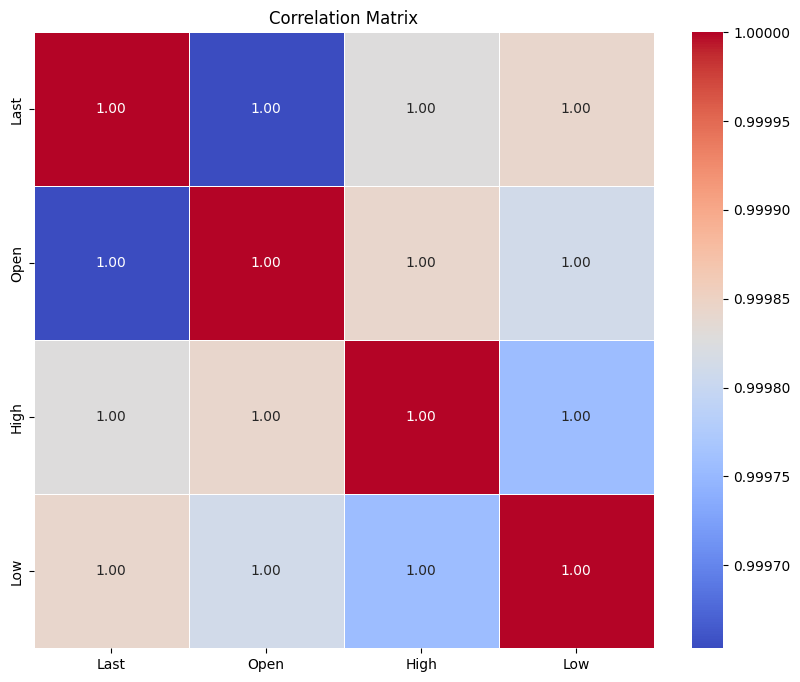

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing the independent variables
# Compute the correlation matrix
correlation_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

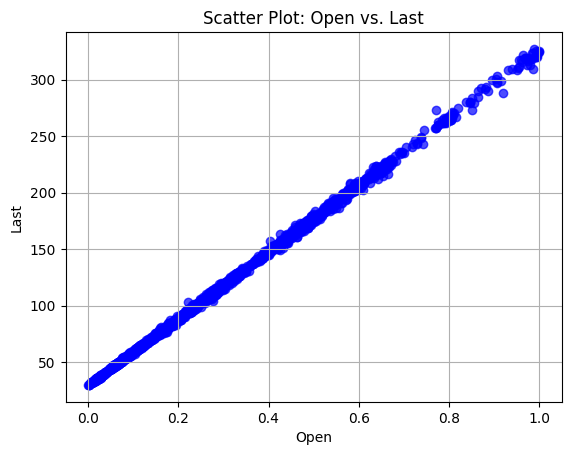

In [15]:
import matplotlib.pyplot as plt

# Scatter plot of Open vs. Last
plt.scatter(df['Open'], df['Last'], alpha=0.7, color='blue')
plt.title('Scatter Plot: Open vs. Last')
plt.xlabel('Open')
plt.ylabel('Last')
plt.grid(True)
plt.show()

In [75]:
train_y


array([[[ 29.8557]],

       [[ 29.8357]],

       [[ 29.9043]],

       ...,

       [[175.5   ]],

       [[178.97  ]],

       [[178.39  ]]])

In [65]:
train_X_reshaped.shape

(2014, 3)

In [28]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


LR = LinearRegression()
# Reshape train_X and test_X to 2D arrays with shape (samples, features)
train_X_reshaped = train_X.reshape(train_X.shape[0], -1)
test_X_reshaped = test_X.reshape(test_X.shape[0], -1)

# Fit the Linear Regression model
LR.fit(train_X_reshaped, train_y.reshape(-1, 1))
pred_y = LR.predict(test_X_reshaped)


mse = mean_squared_error(test_y.reshape(1,-1), pred_y.reshape(1,-1))
mse


1.653580040997836

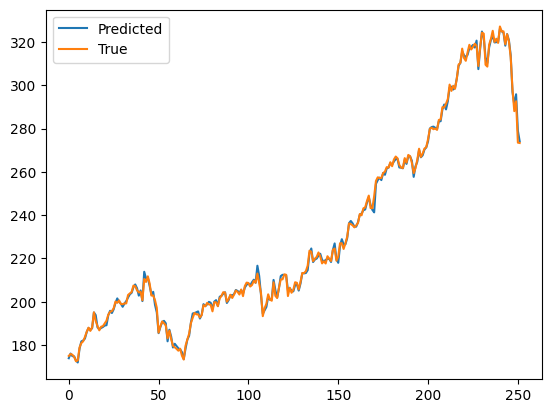

In [54]:
plt.plot(pred_y, label='Predicted')
plt.plot(test_y.reshape(-1,1), label="True")  

plt.legend()

In [56]:
val_y.reshape(1,-1)

array([[178.12, 175.  , 176.21, 176.82, 176.67, 175.03, 176.94, 179.98,
        181.72, 179.97, 178.44, 178.65, 178.02, 175.3 , 175.24, 171.27,
        168.85, 164.94, 172.77, 168.34, 166.48, 167.78, 166.68, 168.39,
        171.61, 172.8 , 168.38, 170.05, 173.25, 172.44, 174.14, 174.73,
        175.82, 178.24, 177.84, 172.8 , 165.72, 165.24, 162.94, 163.65,
        164.22, 162.32, 165.26, 169.1 , 176.57, 176.89, 183.83, 185.16,
        186.05, 187.36, 190.04, 188.59, 188.15, 186.44, 188.18, 186.99,
        186.31, 187.63, 187.16, 188.36, 188.15, 188.58, 187.9 , 187.5 ,
        186.87, 190.24, 191.83, 193.31, 193.98, 193.46, 191.7 , 191.23,
        192.28, 190.7 , 190.8 , 188.84, 188.74, 185.69, 186.5 , 185.46,
        184.92, 182.17, 184.43, 184.16, 185.5 , 185.11, 187.18, 183.92,
        185.4 , 187.97, 190.58, 190.35, 187.88, 191.03, 191.33, 190.91,
        191.45, 190.4 , 191.88, 191.44, 191.61, 193.  , 194.82, 194.21,
        190.98, 189.91, 190.29, 201.5 , 207.39, 207.99, 209.07, 

In [60]:
val_pred_y.shape


(252, 1)

1.2950875044767172


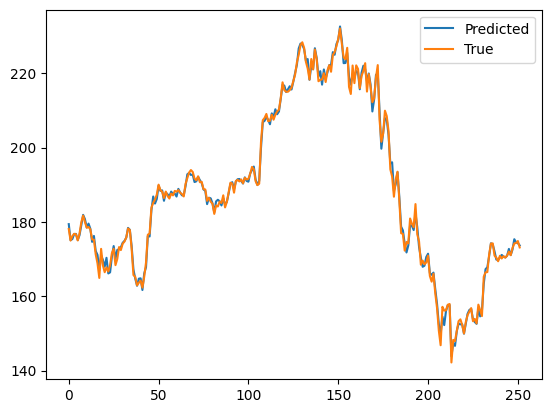

In [61]:
val_pred_y = LR.predict(val_X.reshape(val_X.shape[0],-1))
mse = mean_squared_error(val_y.reshape(1,-1), val_pred_y.reshape(1,-1))
print(mse)
plt.plot(val_pred_y, label='Predicted')
plt.plot(val_y.reshape(-1,1), label="True")  


plt.legend()

## XGBoost

In [62]:
%pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.2 MB/s eta 0:00:0000:010:01
Note: you may need to restart the kernel to use updated packages.


In [71]:

import xgboost as xgb

# Initialize the XGBoost model
xgb = xgb.XGBRegressor(booster='gblinear' ,objective='reg:squarederror',)

# Train the xgb
xgb.fit(train_X_reshaped, train_y.reshape(-1))

# Make predictions
predictions = xgb.predict(test_X_reshaped)

# Evaluate the model
mse = mean_squared_error(test_y.reshape(-1), predictions)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 4.98729276053279


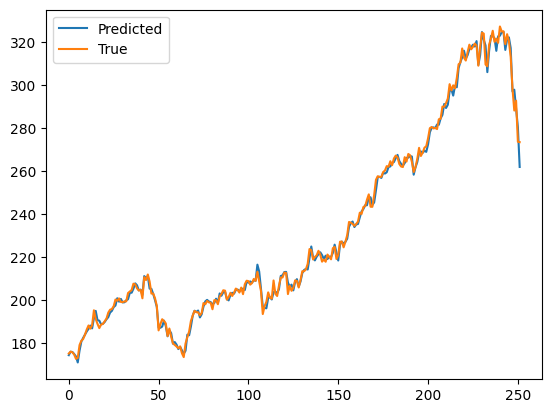

In [72]:
plt.plot(predictions, label='Predicted')
plt.plot(test_y.reshape(-1,1), label="True")  


plt.legend()

## SVR

In [46]:
from sklearn.svm import SVR
regressor = SVR(kernel='linear', C=1.0, gamma='scale')
regressor.fit(train_X_reshaped, train_y.reshape(-1))

SVR(kernel='linear')

In [47]:
y_pred = regressor.predict(test_X_reshaped)
# y_pred = sc_y.inverse_transform(y_pred) 
y_pred

array([173.34588889, 175.02630489, 174.7213719 , 173.9368969 ,
       172.68647143, 170.23005387, 175.87451054, 179.86603832,
       181.32851169, 182.68088097, 184.45211341, 185.79839927,
       186.87412229, 185.94743525, 191.1434837 , 193.65719756,
       189.12195177, 188.79357397, 187.46978245, 187.79671602,
       188.59437408, 189.66092644, 191.29135467, 193.37357755,
       193.83117588, 195.54840572, 196.7084501 , 199.81556833,
       198.23160981, 199.11535338, 197.54479079, 197.84838056,
       198.82177439, 199.52785165, 202.26108713, 202.36664976,
       204.33907864, 206.59223227, 205.53567658, 202.9900878 ,
       203.72859086, 200.8533288 , 210.39940617, 209.14072098,
       209.91946183, 204.51910619, 203.67515099, 201.9970013 ,
       198.59602568, 195.38577723, 185.79946565, 186.30307816,
       187.13770121, 189.50909256, 187.32071831, 181.87733827,
       185.11535241, 183.45738474, 178.57600069, 179.50572222,
       178.33804247, 176.47209145, 177.15718324, 175.62

In [48]:
mse = mean_squared_error(test_y.reshape(1,-1), y_pred.reshape(1,-1))
mse

6.448424663945589

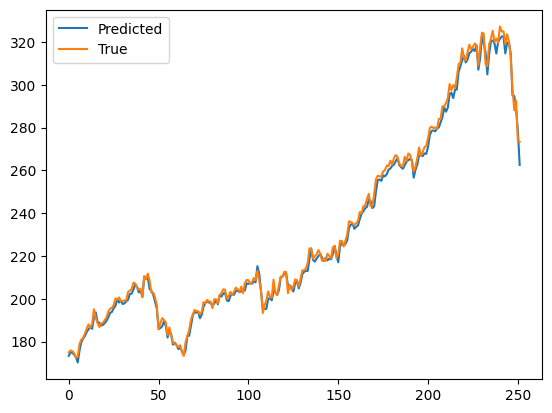

In [49]:
plt.plot(y_pred, label='Predicted')
plt.plot(test_y.reshape(-1), label="True")  

plt.legend()

## RNN

In [43]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, LSTM, Dropout
from keras.optimizers import Adam, SGD


In [44]:
# Define the model
model = Sequential()


# Define the LSTM layer with the corrected input shape
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True)),
Dropout(0.2),
model.add(LSTM(64, return_sequences=True)) ,
Dropout(0.2),
# model.add(LSTM(10, return_sequences=True)) 
model.add(Dense(1))

In [45]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 1, 128)         │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 1, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1, 1)           │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,057 (457.25 KB)

 Trainable params: 117,057 (457.25 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
from tensorflow.keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

model.compile(optimizer = "rmsprop", loss = root_mean_squared_error, 
              metrics =["accuracy"])

In [60]:
# Fit the model
history = model.fit(train_X,train_y , validation_data=(val_X, val_y),epochs=100, batch_size=16)

Epoch 1/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0000e+00 - loss: 97.7605 - val_accuracy: 0.0000e+00 - val_loss: 175.4879
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 85.0396 - val_accuracy: 0.0000e+00 - val_loss: 165.5791
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 77.1915 - val_accuracy: 0.0000e+00 - val_loss: 159.2741
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 71.5520 - val_accuracy: 0.0000e+00 - val_loss: 153.0219
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 66.5444 - val_accuracy: 0.0000e+00 - val_loss: 146.7878
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 60.3937 - val_accuracy: 0.0000e+00 - val_loss: 140.5733
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 55.5554 - val_accuracy: 0.0000e+00 - val_loss: 134.3642
Epoch 8/100
126/126 

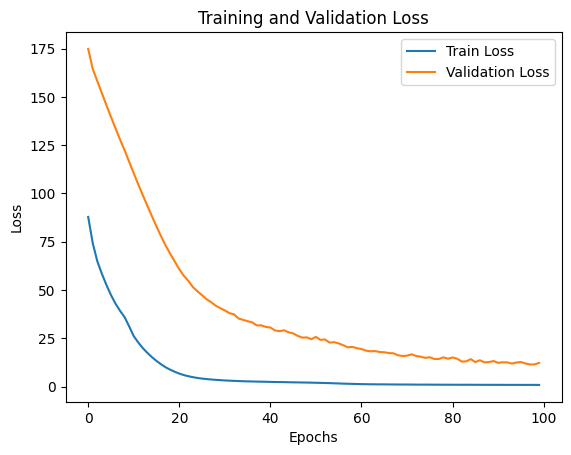

In [ ]:

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [36]:
preicted_y = model.predict(test_X)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


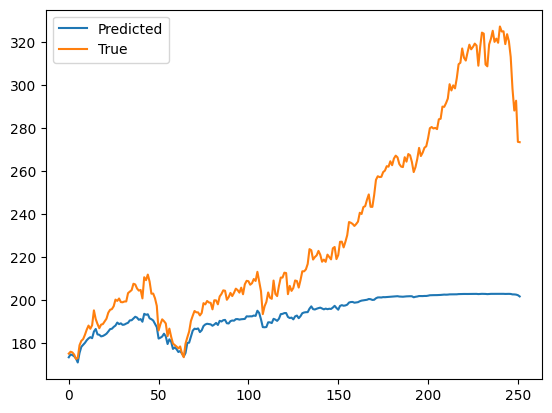

In [37]:
plt.plot(preicted_y.reshape(-1), label='Predicted')
plt.plot(test_y.reshape(-1), label="True")  

plt.legend()

## Grid search

In [23]:
%pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 948.9 kB/s eta 0:00:000:00:01
Note: you may need to restart the kernel to use updated packages.


In [67]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the model as a function for Keras Tuner
def build_model(hp):
    model = Sequential([
        LSTM(
            units=hp.Int('units', min_value=50, max_value=200, step=50),
            return_sequences=True,
            input_shape=(train_X.shape[1], train_X.shape[2])
        ),
        Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)),
        LSTM(
            units=hp.Int('units', min_value=50, max_value=200, step=50),
            return_sequences=False
        ),
        Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)),
        Dense(1)
    ])
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop','sgd']),
        loss=hp.Choice('loss',values = ['mse','rmse'])
    )
    return model

# Initialize the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Number of random combinations to try
    executions_per_trial=1,
    directory='grid_search',
    project_name='lstm_tuning'
)

# Perform the search
tuner.search(train_X, train_y, epochs=50, validation_data=(val_X, val_y), verbose=1)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

# Build the best model
best_model = tuner.hypermodel.build(best_hps)

Reloading Tuner from grid_search/lstm_tuning/tuner0.json
Best Hyperparameters: {'units': 100, 'dropout_rate': 0.1, 'optimizer': 'sgd', 'loss': 'mse'}


/Users/Neha.Duggirala/anaconda3/envs/gen-ai/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
